In [6]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import bayesflow as bf
import tensorflow as tf

from functools import partial
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# Amortized Posterior Estimation for Complex Agent-Based Model
**Boids in BayesFlow** 

In [8]:
## Constants

# Physical dimensions (in meters)
PHYSICAL_WIDTH = 8
PHYSICAL_HEIGHT = 10

# Number of boids
NUM_BOIDS = 50

# Maximum speed and force
MAX_SPEED = 1.5  # m/s
MAX_FORCE = 0.03  # m/s^2

# Perception radii (in meters)
ALIGNMENT_RADIUS = 2.5
COHESION_RADIUS = 5.0
SEPARATION_RADIUS = 1.0

Simulator

In [2]:
class Boid:
    def __init__(self, x, y):
        self.position = np.array([x, y], dtype=float)
        angle = np.random.uniform(0, 2 * np.pi)
        self.velocity = np.array([np.cos(angle), np.sin(angle)], dtype=float)
        self.acceleration = np.zeros(2, dtype=float)

    def apply_force(self, force):
        self.acceleration += force

    def update(self):
        self.velocity += self.acceleration
        speed = np.linalg.norm(self.velocity)
        if speed > MAX_SPEED:
            self.velocity = (self.velocity / speed) * MAX_SPEED
        self.position += self.velocity
        self.acceleration *= 0

        # Wrap around the screen
        self.position = self.position % np.array([PHYSICAL_WIDTH, PHYSICAL_HEIGHT])

    def align(self, boids):
        steering = np.zeros(2)
        total = 0
        for boid in boids:
            if boid != self:
                distance = np.linalg.norm(self.position - boid.position)
                if distance < ALIGNMENT_RADIUS:
                    steering += boid.velocity
                    total += 1
        if total > 0:
            steering /= total
            steering = self.set_magnitude(steering, MAX_SPEED) - self.velocity
            steering = self.limit(steering, MAX_FORCE)
        return steering

    def cohesion(self, boids):
        steering = np.zeros(2)
        total = 0
        for boid in boids:
            if boid != self:
                distance = np.linalg.norm(self.position - boid.position)
                if distance < COHESION_RADIUS:
                    steering += boid.position
                    total += 1
        if total > 0:
            steering /= total
            steering -= self.position
            steering = self.set_magnitude(steering, MAX_SPEED) - self.velocity
            steering = self.limit(steering, MAX_FORCE)
        return steering

    def separation(self, boids):
        steering = np.zeros(2)
        total = 0
        for boid in boids:
            if boid != self:
                distance = np.linalg.norm(self.position - boid.position)
                if distance < SEPARATION_RADIUS:
                    diff = self.position - boid.position
                    if distance > 0:
                        diff /= distance  # Weight by distance
                    steering += diff
                    total += 1
        if total > 0:
            steering /= total
        if np.linalg.norm(steering) > 0:
            steering = self.set_magnitude(steering, MAX_SPEED) - self.velocity
            steering = self.limit(steering, MAX_FORCE)
        return steering

    def flock(self, boids):
        alignment = self.align(boids)
        cohesion = self.cohesion(boids)
        separation = self.separation(boids)

        self.apply_force(alignment)
        self.apply_force(cohesion)
        self.apply_force(separation)

    @staticmethod
    def set_magnitude(vector, magnitude):
        norm = np.linalg.norm(vector)
        if norm == 0:
            return vector
        return vector * (magnitude / norm)

    @staticmethod
    def limit(vector, max_value):
        norm = np.linalg.norm(vector)
        if norm > max_value:
            return vector * (max_value / norm)
        return vector

In [9]:
# Initialize boids
boids = [Boid(np.random.uniform(0, PHYSICAL_WIDTH), np.random.uniform(0, PHYSICAL_HEIGHT)) for _ in range(NUM_BOIDS)]

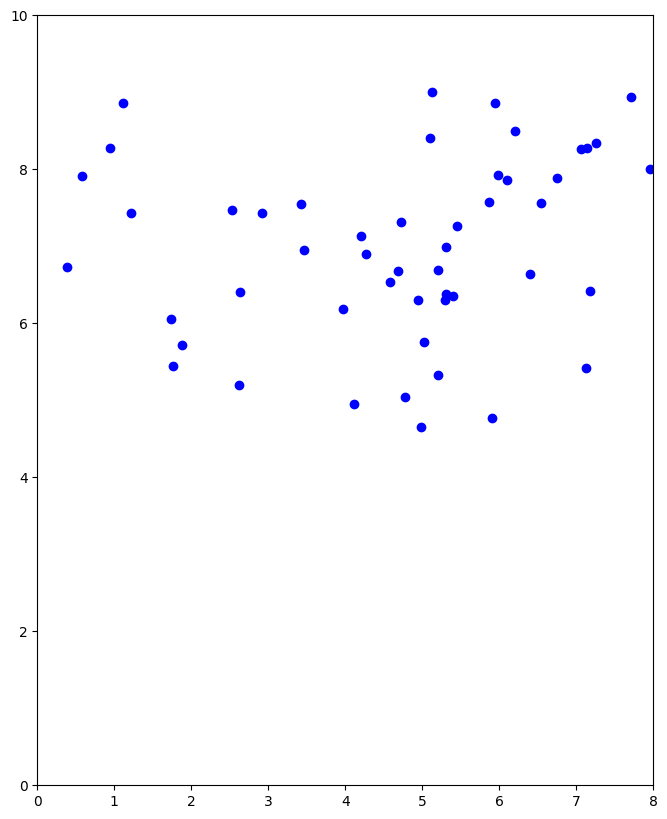

In [10]:
# Animation update function
def update(frame):
    plt.clf()
    for boid in boids:
        boid.flock(boids)
        boid.update()
        plt.scatter(boid.position[0], boid.position[1], color='b')

    plt.xlim(0, PHYSICAL_WIDTH)
    plt.ylim(0, PHYSICAL_HEIGHT)
    plt.gca().set_aspect('equal', adjustable='box')

# Create animation
fig = plt.figure(figsize=(8, 10))
anim = FuncAnimation(fig, update, frames=200, interval=50)
HTML(anim.to_jshtml())